# Advanced Analytics

After validating the dataset through exploratory analysis, this section focuses on deeper behavioral and operational insights derived from the analytical dataset.

The objective is to move beyond descriptive exploration and analyze patterns that can inform business decisions and operational strategy. This includes customer spending segmentation, logistics performance in relation to order characteristics, and temporal purchasing behavior.

The analyses performed in this notebook aim to:

- Identify spending patterns and customer segments
- Explore relationships between logistics performance and order value
- Understand temporal purchasing dynamics
- Detect operational patterns that could impact business performance

These insights provide a bridge between exploratory analysis and business-oriented conclusions, forming the basis for strategic recommendations and predictive modeling explored later in the project.


## Imports and connection with database.

In [1]:
import pandas as pd
import sqlite3
from pathlib import Path
import matplotlib.pyplot as plt

DB_PATH = Path("../data/olist.db")
conn = sqlite3.connect(DB_PATH)

df = pd.read_sql_query(
    "SELECT * FROM analytics_orders;",
    conn
)

#df.head()

## Sanity Check

In [2]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96477 entries, 0 to 96476
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   order_id             96477 non-null  object 
 1   customer_id          96477 non-null  object 
 2   customer_state       96477 non-null  object 
 3   date                 96477 non-null  object 
 4   total_paid           96477 non-null  float64
 5   payment_types        96477 non-null  object 
 6   order_revenue        96477 non-null  float64
 7   delivery_days        96469 non-null  float64
 8   year_month           96477 non-null  object 
 9   day_of_week          96477 non-null  object 
 10  purchase_hour        96477 non-null  object 
 11  month                96477 non-null  int64  
 12  payment_types_count  96477 non-null  int64  
 13  number_of_items      96477 non-null  int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 10.3+ MB


,total_paid,order_revenue,delivery_days,month,payment_types_count,number_of_items
count,96477.000000,96477.000000,96469.000000,96477.000000,96477.000000,96477.000000
mean,159.856357,159.827008,12.093170,6.031085,1.022617,1.142179
std,218.813144,218.795346,9.550476,3.228394,0.148679,0.538773
min,9.590000,9.590000,0.000000,1.000000,1.000000,1.000000
25%,61.880000,61.850000,6.000000,3.000000,1.000000,1.000000
50%,105.280000,105.280000,10.000000,6.000000,1.000000,1.000000
75%,176.330000,176.260000,15.000000,8.000000,1.000000,1.000000
max,13664.080000,13664.080000,209.000000,12.000000,2.000000,21.000000


Based on the analysis performed in 01_eda.ipynb, no rows were lost.

In [3]:
df["purchase_hour"].describe()


count     96477
unique       24
top          16
freq       6476
Name: purchase_hour, dtype: object

In [4]:
df["purchase_hour"].value_counts().sort_index()

purchase_hour
00    2321
01    1133
02     496
03     259
04     203
05     182
06     478
07    1199
08    2907
09    4647
10    5978
11    6385
12    5802
13    6309
14    6383
15    6249
16    6476
17    5963
18    5585
19    5801
20    6007
21    6040
22    5659
23    4015
Name: count, dtype: int64

We do not observe problems in this field.

## Spending-Based Segmentation

We will divide the orders into three groups based on their spending.

In [5]:
df["spend_segment"] = pd.qcut(
    df["total_paid"],
    q=3,
    labels=["low", "medium", "high"]
)

* Revenue by group:

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_17676\4013184434.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg = df.groupby("spend_segment")["total_paid"].sum() / df["total_paid"].sum()


<Axes: title={'center': 'Revenue by Spending Segment'}, xlabel='spend_segment'>

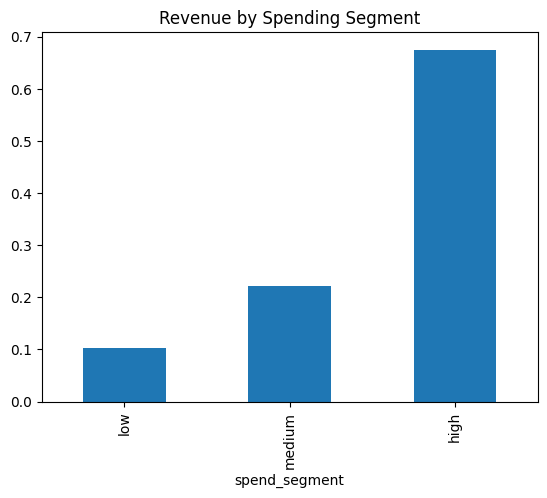

In [6]:
seg = df.groupby("spend_segment")["total_paid"].sum() / df["total_paid"].sum()

seg.plot(kind="bar", title="Revenue by Spending Segment")


* Number of orders by group:

<Axes: title={'center': 'Proportion of Orders by Segment'}, xlabel='spend_segment'>

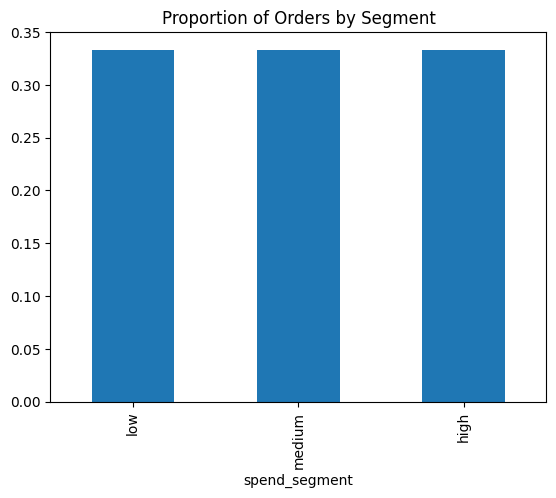

In [7]:
orders_pct = df["spend_segment"].value_counts(normalize=True).sort_index()

orders_pct.plot(kind="bar", title="Proportion of Orders by Segment")

Since we used `qcut`, the three groups contain the same number of orders.

* Average ticket by group

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_17676\2527725492.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_ticket = df.groupby("spend_segment")["total_paid"].mean()


<Axes: title={'center': 'Average ticket by segment'}, xlabel='spend_segment'>

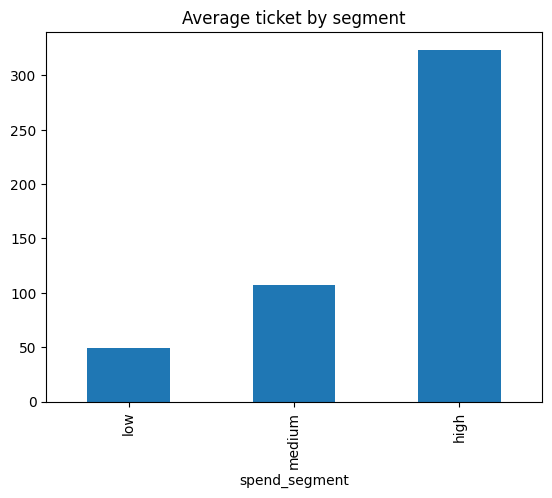

In [8]:
avg_ticket = df.groupby("spend_segment")["total_paid"].mean()

avg_ticket.plot(kind="bar", title="Average ticket by segment")

**Key Insights:**

* Although the segments have a similar volume of orders, the high-spending segment accounts for a significantly larger share of the total revenue.

* The average order value increases stepwise between segments, highlighting a strong heterogeneity in the economic value of orders.

* This suggests that strategies targeted at high-spending customers could have a disproportionately high impact on overall revenue.

## Logistics vs. Spend

We will analyze whether there is a relationship between how much a customer spends and how quickly they receive their order.

* Average Delivery Time by Spending Segment

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_17676\2759482589.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delivery_by_segment = df.groupby("spend_segment")["delivery_days"].mean()


<Axes: title={'center': 'Average Delivery Time by Spending Segment'}, xlabel='spend_segment'>

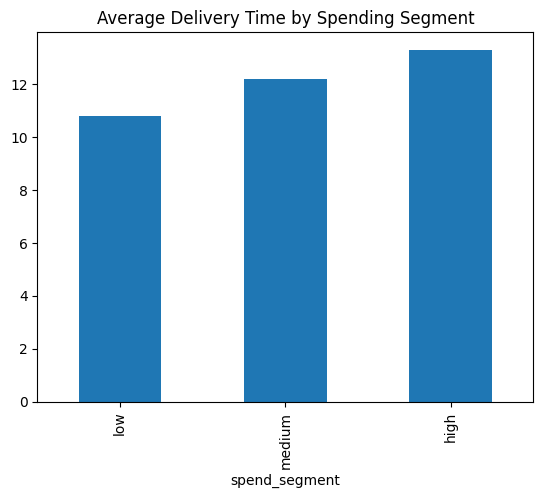

In [9]:
delivery_by_segment = df.groupby("spend_segment")["delivery_days"].mean()

delivery_by_segment.plot(
    kind="bar",
    title="Average Delivery Time by Spending Segment"
)

* Median for each segment:

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_17676\2097939305.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("spend_segment")["delivery_days"].median().plot(kind="bar", title= "Delivery median for spend segment")


<Axes: title={'center': 'Delivery median for spend segment'}, xlabel='spend_segment'>

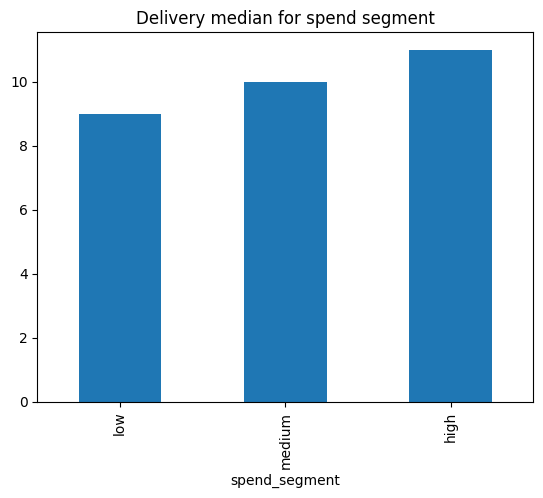

In [10]:
df.groupby("spend_segment")["delivery_days"].median().plot(kind="bar", title= "Delivery median for spend segment")

* Dispersion for Each Segment

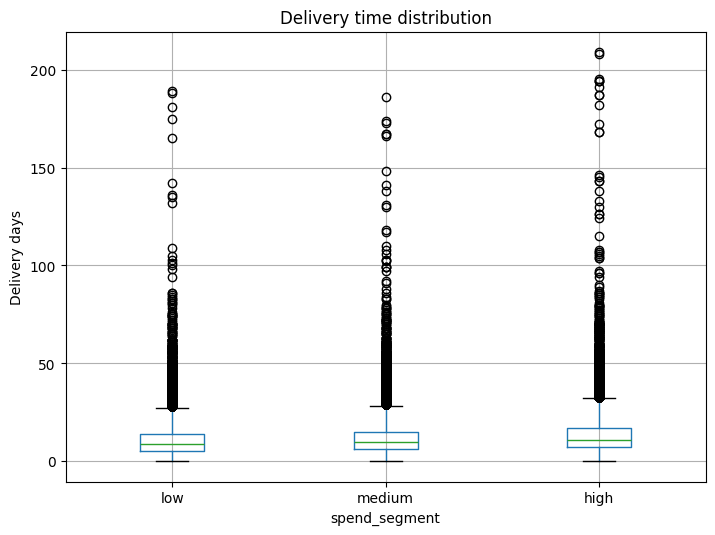

In [11]:
df.boxplot(
    column="delivery_days",
    by="spend_segment",
    figsize=(8,6)
)

plt.title("Delivery time distribution")
plt.suptitle("")
plt.ylabel("Delivery days")
plt.show()

In [12]:
df.groupby("spend_segment")["delivery_days"].agg(["mean","median","std","count"])

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_17676\114225161.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("spend_segment")["delivery_days"].agg(["mean","median","std","count"])


,mean,median,std,count
spend_segment,,,,
low,10.798290,9.0,8.702005,32165
medium,12.192119,10.0,9.345847,32152
high,13.289624,11.0,10.366205,32152


**Key Insights:**

The analysis shows a progressive increase in both the average and median delivery times as the order value increases. Furthermore, greater variability in delivery times is observed within the high-spending segment. This could be related to differences in logistical complexity, product characteristics, or shipping distances. The presence of numerous outliers is consistent with the nature of real-world logistics processes, where exceptional delays can occur.

## Hourly Behavior

* Number of orders per hour:

Text(0.5, 1.0, 'Orders per hour')

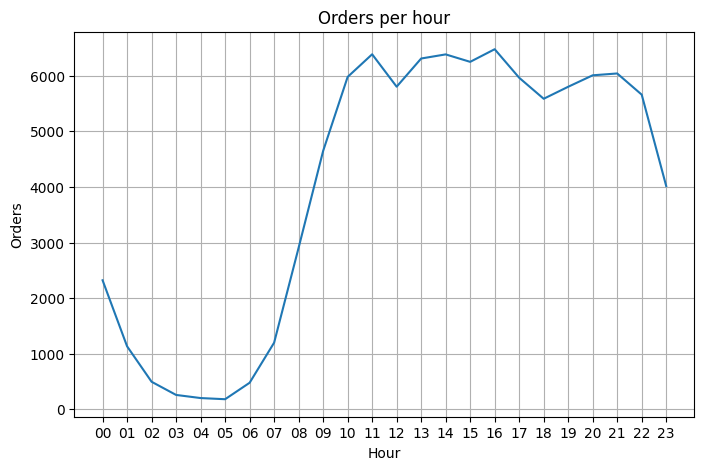

In [13]:
orders_by_hour = df.groupby("purchase_hour")["order_id"].count()


plt.figure(figsize=(8,5))

plt.plot(orders_by_hour)
plt.xlabel("Hour")
plt.ylabel("Orders")
plt.grid()
plt.title("Orders per hour")


* Average ticket per hour:

Text(0.5, 1.0, 'Average ticket per hour')

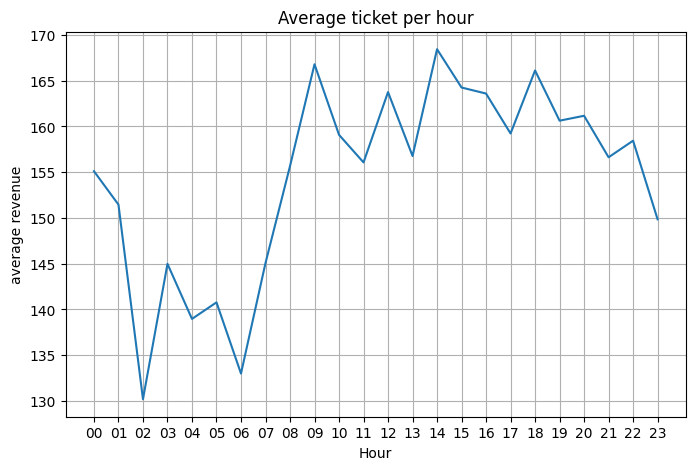

In [14]:
avg_ticket_hour = df.groupby("purchase_hour")["total_paid"].mean()


plt.figure(figsize=(8,5))

plt.plot(avg_ticket_hour)
plt.xlabel("Hour")
plt.ylabel("average revenue")
plt.grid()
plt.title("Average ticket per hour")


* Total revenue per hour

Text(0.5, 1.0, 'Revenue by hour')

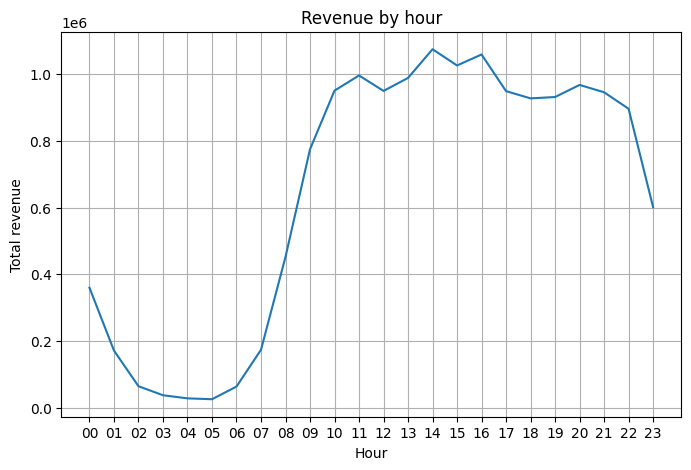

In [15]:
revenue_by_hour = df.groupby("purchase_hour")["total_paid"].sum()

plt.figure(figsize=(8,5))

plt.plot(revenue_by_hour)
plt.xlabel("Hour")
plt.ylabel("Total revenue")
plt.grid()
plt.title("Revenue by hour")

* Hour vs day of the week matrix

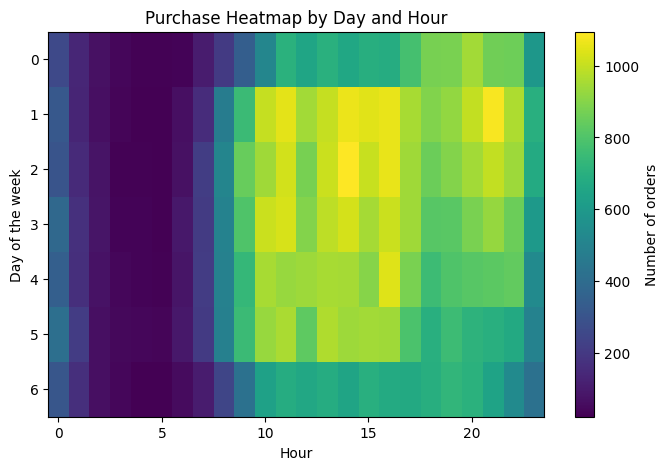

In [16]:
pivot = df.pivot_table(
    values="order_id",
    index="day_of_week",
    columns="purchase_hour",
    aggfunc="count"
)

plt.figure(figsize=(8,5))
plt.imshow(pivot, aspect="auto")
plt.colorbar(label="Number of orders")

plt.title("Purchase Heatmap by Day and Hour")
plt.xlabel("Hour")
plt.ylabel("Day of the week")

plt.show()

In [17]:
pivot

purchase_hour,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
day_of_week,,,,,,,,,,,,,,,,,,,,,
0,256,137,68,41,27,26,30,102,202,341,...,660,696,688,777,875,881,944,863,858,591
1,315,132,63,34,21,22,64,157,471,752,...,1063,1047,1060,954,891,920,998,1083,962,697
2,300,151,79,28,28,24,69,216,510,845,...,1095,1005,1059,943,852,894,946,996,939,676
3,385,171,81,31,33,24,91,208,497,798,...,1027,952,1008,943,818,822,881,927,855,600
4,345,165,74,38,30,28,82,211,495,736,...,951,901,1042,881,759,798,816,826,835,533
5,412,210,66,46,39,35,91,203,487,754,...,937,948,943,791,697,757,714,700,675,496
6,308,167,65,41,25,23,51,102,245,421,...,650,700,676,674,693,729,708,645,535,422


**Key Insights:**

The analysis shows that the highest order volume is concentrated between 10:00 and 21:00 (10 AM and 9 PM), with peaks around midday. These same time ranges also record the highest values in both average order value and total revenue, suggesting that the highest income is associated with peak activity hours rather than atypical time slots.

Furthermore, the heatmap reveals that the highest number of purchases occurs on weekdays, particularly in the first half of the week, where the highest levels of activity are concentrated.

## Performance vs State

* Base Metrics by State:

In [18]:
state_perf = df.groupby("customer_state").agg(
    total_orders=("order_id", "count"),
    total_revenue=("total_paid", "sum"),
    avg_ticket=("total_paid", "mean"),
    avg_delivery_days=("delivery_days", "mean")
).sort_values("total_revenue", ascending=False)

state_perf.head()

,total_orders,total_revenue,avg_ticket,avg_delivery_days
customer_state,,,,
SP,40500,5770266.19,142.475708,8.296965
RJ,12350,2055690.45,166.452668,14.848583
MG,11354,1819277.61,160.232307,11.542188
RS,5345,861802.40,161.235248,14.819237
PR,4923,781919.55,158.829890,11.526711


* Revenue by state (Top 10)

<Axes: title={'center': 'Top states by revenue'}, xlabel='customer_state'>

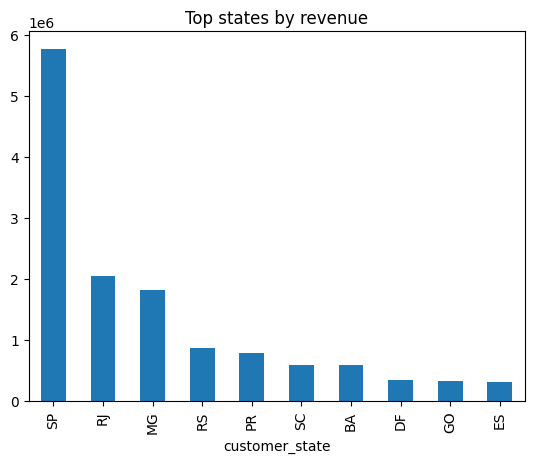

In [19]:
state_perf["total_revenue"].head(10).plot(kind="bar", title="Top states by revenue")

* Ticket promedio por estado

<Axes: title={'center': 'States with higher average ticket'}, xlabel='customer_state'>

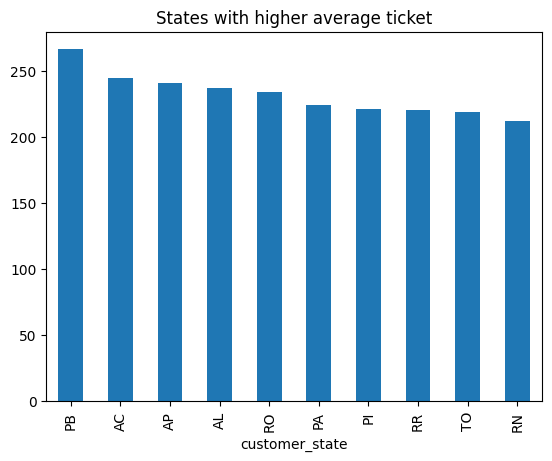

In [20]:
state_perf.sort_values("avg_ticket", ascending=False)["avg_ticket"].head(10)\
    .plot(kind="bar", title="States with higher average ticket")


* Delivery vs Revenue

<Axes: title={'center': 'Average devlivery vs Revenue by state'}, xlabel='avg_delivery_days', ylabel='total_revenue'>

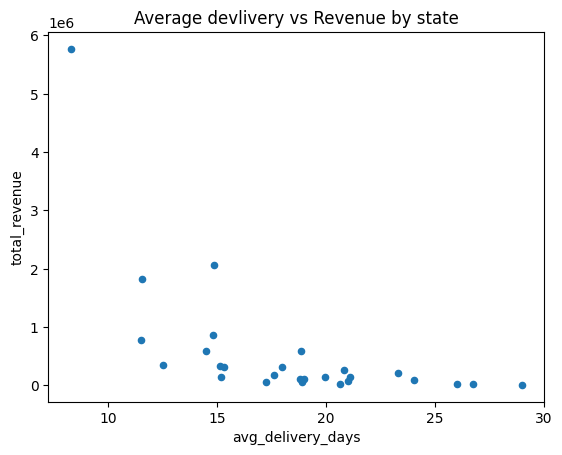

In [21]:
state_perf.plot.scatter(
    x="avg_delivery_days",
    y="total_revenue",
    title="Average devlivery vs Revenue by state"
)


**Key Insights:**

The geographic analysis reveals a strong concentration of revenue in certain states, with São Paulo standing out as the primary income generator. However, this leadership appears to be primarily driven by order volume rather than higher individual customer spending.

In fact, when examining the average order value, it is evident that the states with the highest total revenue do not coincide with those showing the highest spending per order. This suggests the existence of two distinct dynamics: states with high commercial activity and purchase volume, versus states with a lower number of orders but higher average tickets.

Furthermore, the joint analysis of revenue and delivery time indicates a negative relationship between both variables. States with higher revenue volumes tend to have lower delivery times. While this relationship does not imply direct causality, it may be associated with structural factors such as better logistics infrastructure, higher population density, or proximity to distribution centers.

Taken together, these results highlight the importance of simultaneously analyzing volume, spending behavior, and operational variables to understand regional differences in business performance.